# Imports

In [62]:
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Task 1

In [4]:
class Tree:
    '''Create a binary tree; keyword-only arguments `data`, `left`, `right`.
    Examples:
    l1 = Tree.leaf("leaf1")
    l2 = Tree.leaf("leaf2")
    tree = Tree(data="root", left=l1, right=Tree(right=l2))
    '''

    def leaf(data):
        '''Create a leaf tree
        '''
        return Tree(data=data)

    # pretty-print trees
    def __repr__(self):
        if self.is_leaf():
            return "Leaf(%r)" % self.data
        else:
            return "Tree(%r) { left = %r, right = %r }" % (self.data, self.left, self.right)

    # all arguments after `*` are *keyword-only*!
    def __init__(self, *, data = None, left = None, right = None):
        self.data = data
        self.left = left
        self.right = right

    def is_leaf(self):
        '''Check if this tree is a leaf tree
        '''
        return self.left == None and self.right == None

    def children(self):
        '''List of child subtrees
        '''
        return [x for x in [self.left, self.right] if x]

    def depth(self):
        '''Compute the depth of a tree
        A leaf is depth-1, and a child is one deeper than the parent.
        '''
        return max([x.depth() for x in self.children()], default=0) + 1

In [5]:
leaf_nah = Tree.leaf('nah')
leaf_like = Tree.leaf('like')
Tree1 = Tree(data = 'likedOtherSys?', left = leaf_nah, right = leaf_like)
Tree2 = Tree(data = 'morning?', left = leaf_like, right = leaf_nah)
Tree3 = Tree(data = 'takenOtherSys?', left = Tree2, right = Tree1)
Tree4 = Tree(data = 'isSystems?', left = leaf_like, right = Tree3)
print(Tree4)

Tree('isSystems?') { left = Leaf('like'), right = Tree('takenOtherSys?') { left = Tree('morning?') { left = Leaf('like'), right = Leaf('nah') }, right = Tree('likedOtherSys?') { left = Leaf('nah'), right = Leaf('like') } } }


# Task 2

In [13]:
df = pd.read_csv('data.csv')
df['ok'] = df['rating']>= 0 

In [14]:
df.head(2)

,rating,easy,ai,systems,theory,morning,ok
0,2,True,True,False,True,False,True
1,2,True,True,False,True,False,True


# Task 3

In [84]:
def single_feature_score(data, goal, feature):
    
    true_items = data[data[feature] == True][goal]
    false_items = data[data[feature] == False][goal]
    
    true_matching = 0
    false_matching = 0
    
    if len(true_items) != 0:
        true_most_common = Counter(true_items.tolist()).most_common(1)[0][0]
        true_matching = true_items.value_counts()[true_most_common]        
    
    if len(false_items) != 0:
        false_most_common = Counter(false_items.tolist()).most_common(1)[0][0]
        false_matching = false_items.value_counts()[false_most_common]      
    
    return (true_matching + false_matching) / len(data)

In [85]:
def best_and_worst_feature(data, goal, features):
    scorer = partial(single_feature_score, data, goal)
    return max(features, key=scorer), min(features, key=scorer)

In [89]:
features = df.drop(['rating', 'ok'], axis=1).columns.tolist()
b, w =  best_and_worst_feature(df, 'ok', features)
b_score = single_feature_score(df, 'ok', b)
w_score = single_feature_score(df, 'ok', w)
print(f'Best feature is {bf} with score {b_score}')
print(f'Worst feature is {bf} with score {w_score}')

Best feature is systems with score 0.9
Worst feature is systems with score 0.6


# Task 4

In [92]:
len(pd.unique([1, 2, 1]))

2

In [93]:
def DecisionTreeTrain(data, goal, features):
    
    guess = Counter(data[goal].tolist()).most_common(1)[0][0]
    
    if len(features) == 0 or len(pd.unique(data[goal])) == 1:
        return Tree.leaf(guess)
    else:
        b, _ = best_and_worst_feature(data, goal, features)
        remaining_features = features.copy()
        remaining_features.remove(b)        
        true_items = data[data[b] == True]
        false_items = data[data[b] == False]
        
        if len(true_items) != 0:
            right = DecisionTreeTrain(true_items, goal, remaining_features)
        else:
            right = Tree.leaf(guess)
        
        if len(false_items) != 0:
            left = DecisionTreeTrain(false_items, goal, remaining_features)
        else:
            left = Tree.leaf(guess)         
        
        return Tree(data=b, left=left, right=right)
    
def DecisionTreeTest(tree, data_point):
    if tree.is_leaf():
        return tree.data
    else:
        feature_name = tree.data
        if not data_point[feature_name]:
            return DecisionTreeTest(tree.left, data_point)
        else:
            return DecisionTreeTest(tree.right, data_point)

In [94]:
tree = DecisionTreeTrain(df, 'ok', features)
print(tree)

Tree('systems') { left = Leaf(True), right = Tree('easy') { left = Tree('ai') { left = Leaf(False), right = Tree('theory') { left = Tree('morning') { left = Leaf(True), right = Leaf(True) }, right = Leaf(True) } }, right = Tree('theory') { left = Leaf(False), right = Leaf(True) } } }


# Task 5

In [95]:
def DecisionTreeTrainWithMaxDepth(data, goal, features, max_depth):
    
    guess = Counter(data[goal].tolist()).most_common(1)[0][0]
    
    if len(features) == 0 or len(pd.unique(data[goal])) == 1 or max_depth == 0:
        return Tree.leaf(guess)
    else:
        b, _ = best_and_worst_feature(data, goal, features)
        remaining_features = features.copy()
        remaining_features.remove(b)        
        true_items = data[data[b] == True]
        false_items = data[data[b] == False]
        
        if len(true_items) != 0:
            right = DecisionTreeTrainWithMaxDepth(true_items, goal, remaining_features, max_depth-1)
        else:
            right = Tree.leaf(guess)
        
        if len(false_items) != 0:
            left = DecisionTreeTrainWithMaxDepth(false_items, goal, remaining_features, max_depth-1)
        else:
            left = Tree.leaf(guess)         
        
        return Tree(data=b, left=left, right=right)

In [97]:
tree2 = DecisionTreeTrainWithMaxDepth(df, 'ok', features, max_depth=3)
print(tree2)

Tree('systems') { left = Leaf(True), right = Tree('easy') { left = Tree('ai') { left = Leaf(False), right = Leaf(True) }, right = Tree('theory') { left = Leaf(False), right = Leaf(True) } } }


# Perfomance

In [102]:
def calc_accuracy(tree, goal, data):
    data = data.to_dict(orient='records')
    
    y_pred = [DecisionTreeTest(tree, point) for point in data]
    y_true = [point[goal] for point in data]    
    
    N = len(y_pred)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    return (y_true == y_pred).sum() / N

max_depths = [i for i in range(10)]
scores = list()
for i in max_depths:
    tree = DecisionTreeTrainWithMaxDepth(df, 'ok', features, max_depth=i)
    scores.append(calc_accuracy(tree, 'ok', df))

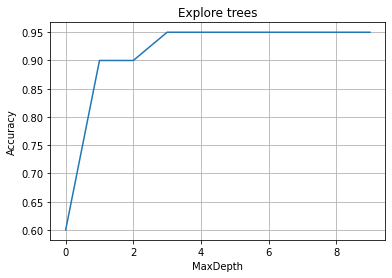

In [105]:
plt.grid(True)
plt.xlabel('MaxDepth')
plt.ylabel('Accuracy')
plt.title('Explore trees')
plt.plot(max_depths, scores)
plt.savefig('plot.png')